# Example 1: Identification of a Nonlinear System Using a Series-Parallel Model


## Problem Summary
**Goal:** Identify a nonlinear function `f(u)` in a system that is represented by the equation:
  
$y_p(k + 1) = 0.3 y_p(k) + 0.6 y_p(k - 1) + f(u(k))$ Where

$f(u) = 0.6 \sin(\pi u) + 0.3 \sin(3\pi u) + 0.1 \sin(5\pi u)$


## Implementation Steps
**Approach:** Use a neural network $N(u)$ to approximate the unknown function $f(u)$ based on input-output data.

**Initial Conditions:** $y_{p}(0)$ and $y_{p}(1)$ are unknown, they are initialized to zero.


1. **Data Preparation**: Generate sequences $u(k)$ and $y_p(k)$, using sinusoidal and random inputs.
2. **Training Process**: Use backpropagation to adjust weights, minimizing the difference between the model output $\hat{y}_p(k + 1)$ and the actual output $y_p(k + 1)$.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# Define the Plant

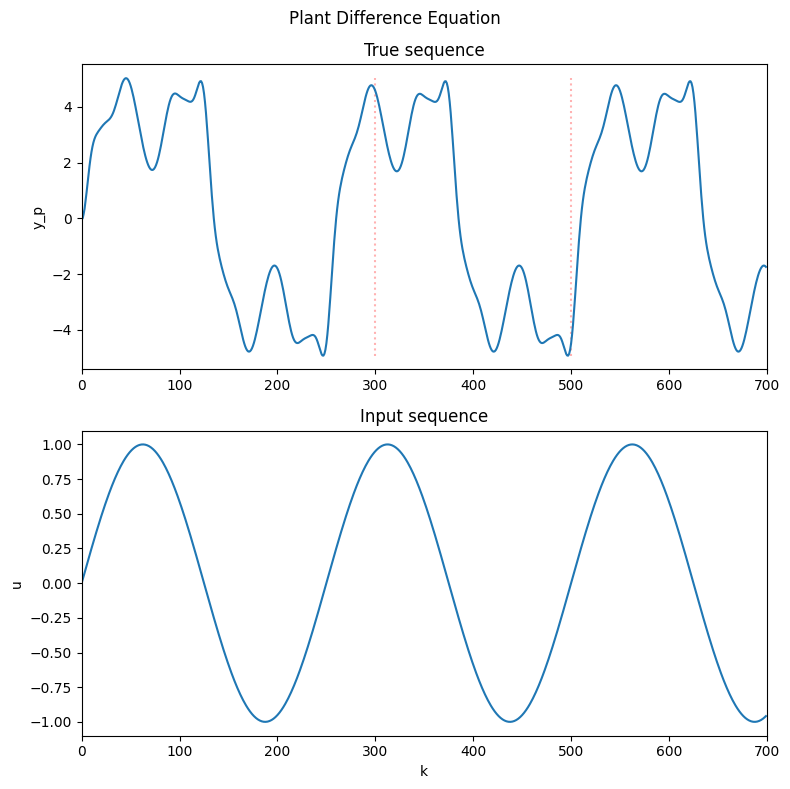

In [2]:
# sequence length (given in paper)
k_ = 700

# Sine wave input (given in paper)
u = np.sin(2 * np.pi * np.arange(k_) / 250)

# Plant non-linear function (given in paper)
def f(u):
    """Function f(u) from the paper."""
    return 0.6 * np.sin(np.pi * u) + 0.3 * np.sin(3 * np.pi * u) + 0.1 * np.sin(5 * np.pi * u)

def y(y_1: float, y_2: float, f: float) -> float:
    """Generate y(k) for the plant on a none-linear function.
    Note that since we are returning y at k (not k+1), we need to pass y_1 and y_2 that refer respectivly to y(k-1) and y(k-2).
    """
    return (0.3 * y_1) + (0.6 * y_2) + f
    

# init y true with assumed initial conditions (y(k=0)=0 and y(k=1)=0)
y_p = np.zeros(k_)

# Generate y_{p} (true sequence) for the plant on the function f(u).
for k in range(1, k_-1):
    y_p[k + 1] = y(y_p[k], y_p[k - 1], f(u[k]))
    # same as:
    # y_p[k+1] = 0.3 * y_p[k] + 0.6 * y_p[k - 1] + f(u[k])


fig, ax = plt.subplots(nrows=2, figsize=(8, 8))

fig.suptitle("Plant Difference Equation")

ax[0].vlines(x=300, ymin=min(y_p), ymax=max(y_p), colors="r", linestyles=":", alpha=0.3)
ax[0].vlines(x=500, ymin=min(y_p), ymax=max(y_p), colors="r", linestyles=":", alpha=0.3)

ax[0].plot(y_p)
ax[0].set_title("True sequence")
ax[0].set_ylabel("y_p")
ax[0].set_xlim([0, k_])

ax[1].plot(u)
ax[1].set_ylabel("u")
ax[1].set_xlabel("k")
ax[1].set_title("Input sequence")
ax[1].set_xlim([0, k_])
plt.tight_layout()
fig.savefig("plant_diff_eq.svg", dpi=300)
plt.show()

# Series-Parallel Model
The Neural Network is `N(u)` (as seen in the paper).

In [3]:
# init
y_hat = torch.from_numpy(np.zeros(k_)).float()

# System parameters
num_epochs = 2000
learning_rate = 0.25

# Initialize the neural network model N(u) to approximate f(u)
N = nn.Sequential(nn.Linear(1, 20),  nn.Tanh(),
                        nn.Linear(20, 10), nn.Tanh(),
                        nn.Linear(10, 1)
                        )

optimizer = optim.Adam(N.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# for debugging
torch.autograd.set_detect_anomaly(True)


Each training step:
1. We provide the network inputs `u(k)`, to get the output `N(u)`.
2. We then pass `N(u)` to `y_hat[k + 1] = y(y_hat[k], y_hat[k - 1], N(u))`

In [4]:
# temp: running training loop by hand
# .view(-1, 1) # one column
u_ = torch.from_numpy(u).view(-1,1).float()
y_p_ = torch.from_numpy(y_p).float()


In [7]:
k = 4

N.train()
optimizer.zero_grad()

t = N(u_[k])

y_hat[k] = y(y_hat[k-1], y_hat[k-2], t)

# loss
loss = criterion(y_hat[k], y_p_[k])

print('Befor calculating the grad:\n', N[0].weight.grad)

loss.backward(retain_graph=True)

print("After calculating the grad:\n", N[0].weight.grad[:2])
print('-'*50)
print("Befor updating:\n", N[0].weight[:2])

optimizer.step()

print("After updating:\n", N[0].weight[:2])
print(loss)

Befor calculating the grad:
 None


/home/firoozas/data/Github_repos/AI-from-scratch/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/firoozas/data/Github_repos/AI-from-scratch/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/firoozas/data/Github_repos/AI-from-scratch/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/firoozas/data/Github_repos/AI-from-scratch/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/firoozas/data/Github_repos/AI-from-scratch/.venv/lib/python3.10/site-

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [10, 1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [6]:
print("After updating:\n", N[0].weight[:2])
print(loss)

After updating:
 tensor([[0.0343],
        [1.1710]], grad_fn=<SliceBackward0>)
tensor(0.1802, grad_fn=<MseLossBackward0>)


In [ ]:
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    # Note that we don't have mini-batches, meaning that we will update the model after each time step
    for k in range(2, k_):  # (1, k_-1)
        optimizer.zero_grad()

        # Prepare inputs for the network
        u_torch = torch.tensor([u[k]], dtype=torch.float32).unsqueeze(0)

        # Compute network approximation for f(u) and full prediction for y_p(k+1)
        f_u_pred = N(u_torch).squeeze()
        y_hat[k] = 0.3 * y_p[k - 1] + 0.6 * y_p[k - 2] + f_u_pred.item()

        # Compute the loss and backpropagate
        y_target = torch.tensor([y_p[k]], dtype=torch.float32)
        loss = criterion(f_u_pred, y_target)
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        epoch_loss += loss.item()

    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / (k_ - 2):.5f}')

# Plot results to check model performance
plt.plot(y_p, label='True Output')
plt.plot(y_hat, label='Model Prediction', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Output')
plt.legend()
plt.show()
